In [1]:
import numpy as np
from qutip import *
from sympy.physics.quantum.cg import CG
from sympy.physics.wigner import wigner_6j, wigner_3j
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs

In [2]:
#toy model's quantum numbers
I = 1
S = 1
Je = 0
Jg = 1
Lg = 2
F = [i for i in range(int(I-Jg),int(I + Jg + 1),1)]
F.insert(0,int(I+Je))
F 

[1, 0, 1, 2]

In [3]:
#number of atomic states
N = [2*F[i] + 1 for i in range(len(F))]
N = sum(N)
N

12

In [4]:
#Zeeman stuff

muB = 9.3e-24 #Bohr magneton J T^-1
hbar = 1.054e-34 # J s

muB = muB/hbar #hbar = 1
muB = muB/(2*np.pi)
muB = muB/1e6  # so it's in 1/2π (MHz T^-1)
#muB=1

# 1Gauss is 0.0001 T
B=5e-04
print(muB*B) 
#gF = [1,0,1,2]
gF = []
FF = [7,6,7,8]
II = 7


#Lande g factor for F
me = 9.1093837015e-31 
mp = 1.67262192369e-27 

mI = 3.169 #nuclear magnetic moment of 176Lu in units of μN
gI = mI/II
gJg = 1 + (Jg*(Jg +1) + S*(S + 1) - Lg*(Lg + 1))/(2*Jg*(Jg + 1))


gF.append(-gI*me/mp)

for i in range(3):
    gF.append(gJg*(FF[i +1]*(FF[i+1] + 1) + Jg*(Jg+1) - II*(II+1))/(2*FF[i+1]*(FF[i +1] + 1)))

    
print(gF)

7.021541606995384
[-0.0002465559058692723, -0.07142857142857142, 0.008928571428571428, 0.0625]


In [9]:
-gI*me/mp

-0.0002465559058692723

In [11]:
for i in range(len(F)):
    print(gF[i]*muB*B) #(1/2π MHz)

-0.0017312025515115329
-0.5015386862139559
0.06269233577674449
0.4388463504372115


In [13]:
def base(F,i,mF):
    #numbering states from 0 to N-1 starting from -mF to mF
    # 0 is |F',-mF'>
    if i==0:
        b = basis(N,mF+F[i])
    elif i==1:
        b = basis(N,mF + F[i] + 2*F[0] + 1)
    elif i==2:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1)
    else:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1 + 2*F[2] +1)
    return b    

## Dissipation

In [16]:
GammaJgJe = 2.44745 #1/2π (MHz) 3D1 to 3P0
#GammaJgJe = 2.5

In [18]:
def GammaFgFe(F,ig,Je,Jg,I,GammaJgJe):
    return float((2*Je + 1)*(2*F[ig] + 1)*wigner_6j(Je,F[0],I,F[ig],Jg,1)**2)*GammaJgJe
    #return GammaJgJe

In [20]:
GammaFgFe(F,1,Je,Jg,I,GammaJgJe) + GammaFgFe(F,2,Je,Jg,I,GammaJgJe) + GammaFgFe(F,3,Je,Jg,I,GammaJgJe)

2.44745

In [22]:
def cg(F,ig,mFg,ie,mFe,q):
    return float(CG(F[ig],mFg,1,q,F[ie],mFe).doit())
    #return 1

In [24]:
def c_ops(F,GammaJgJe):
    c_ops = []
    qs = [-1,0,1]

    for ig in range(1,len(F)):
        for mfg in range(-F[ig],F[ig] + 1):
            for mfe in range(-F[0], F[0] + 1):
                for q in qs:
                    if cg(F,ig,mfg,0,mfe,q) != 0:
                        cops =np.sqrt(1/(2*F[0] + 1))*cg(F,ig,mfg,0,mfe,q)*np.sqrt(GammaFgFe(F,ig,Je,Jg,I,GammaJgJe))*base(F,ig,mfg)*base(F,0,mfe).dag()
                        c_ops.append(cops.to("CSR"))
    return c_ops

## Rest ion

In [27]:
def H_I(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [29]:
def H_0(F,Delta):
    H0 = 0*basis(N,0)*basis(N,0).dag()
    for l in range(len(F)):
        for mF in range(-F[l],F[l]+1):
            H0 +=(Delta[l] + gF[l]*muB*mF*B)*base(F,l,mF)*base(F,l,mF).dag() 
    return H0

In [31]:
def pop_e(F,N,Delta,Omega_p,c_ops,Deltap_min, Deltap_max,nn):   
    
    #number of excited states
    Ne = 2*F[0] + 1

    e = [basis(N,i) for i in range(0,Ne)]
    g = [basis(N,i) for i in range(Ne,N)]

    #Delta = [0,4*GammaJgJe,4*GammaJgJe,4*GammaJgJe + 5]
    i=0
    popes = np.zeros(nn)
    #popgs = np.zeros(nn)
    #rhos = []
    
    #HI - laser-ion interaction      
    HI=H_I(F,Omega_p) 

    for Deltap in tqdm(np.linspace(Dmin,Dmax,nn)):
    #for Deltap in [50,55,60,65,0]:
        
        Delta[2] = Deltap
        
        #H0 - ion
        H0 = H_0(F,Delta)
    
        #total Hamiltonian
        H = H0 + HI
        #make sure Hamiltonian is sparse
        H = H.to("CSR").tidyup(atol=1e-8)
        #print(H)
        
        rho = steadystate(H,c_ops)
        #rhos.append(rho)
        
        for j in range(len(e)):
            popes[i] += expect(e[j]*e[j].dag(),rho)
            
        #for k in range(len(g)):
            #popgs[i] += expect(g[k]*g[k].dag(),rho)
    
        #print(i)
        #print(popgs[i])
        #print(popes[i])
        i+=1
        
    #return popes,popgs,rhos
    return popes

### σ+ and σ- for all transitions

In [34]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [36]:
B = 5e-04
print(muB*B) 
Delta = [0,10,20.5,20]

#Delta[2] = Delta[3] -(gF[2] + gF[3])*muB*B

Delta

7.021541606995384


[0, 10, 20.5, 20]

In [38]:
Delta_ds = []

for mFe in range(-F[0],F[0] + 1):
    for mFg in range(-F[2],F[2] + 1):
        for q in [-1,1]:
            #print(mFg)
            if cg(F,2,mFg,0,mFe,q) != 0:
                #print(F[0],mFe)
                #print(F[2],mFg)
                #print('\n')
                for ig in [1,3]:
                    for mFFg in range(-F[ig],F[ig] + 1):
                        for qq in [-1,1]:
                        #print(mFFg)
                            if cg(F,ig,mFFg,0,mFe,qq) != 0:
                                Delta_ds.append(Delta[ig] - gF[2]*mFg*muB*B + gF[ig]*mFFg*muB*B)

In [40]:
Delta_ds.sort()
Delta_ds[-2]

20.501538686213955

## Fictitious

In [43]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [45]:
def H1_(F,eta,Omega_p):
    H1=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    H1 += eta[ig-1]*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*H1

In [47]:
def steck(F,N,Delta,Omega_p,eta,c,omega):
    H0_ = H_0(F,Delta)
    HI_ = H_I(F,Omega_p) 
    

    H0 = H0_ + HI_ 

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))
    #L0 = sum(c)

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    H_1 = H1_(F,eta,Omega_p)
    L_1 = -1j*(spre(H_1) - spost(H_1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')

    H1 = H_1.dag()
    L1 = -1j*(spre(H1) - spost(H1))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')
   
    #popes = np.zeros(nn,dtype='complex64')
    #coh = np.zeros(nn,dtype='complex64')
    #abs = np.zeros(nn,dtype='complex64')
    
    #k=0



    #S3 = -np.matmul(inv(L0-3j*delta*np.eye(N**2)),L1)
    S2 = -np.matmul(inv(L0-2j*omega*np.eye(N**2)),L1)
    #S2 = -np.matmul(inv(L0-2j*delta*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    S1 = -np.matmul(inv(L0-1j*omega*np.eye(N**2) + np.matmul(L_1,S2)),L1) 

    #T_3 = -np.matmul(inv(L0+3j*delta*np.eye(N**2)),L_1)
    T_2 = -np.matmul(inv(L0+2j*omega*np.eye(N**2)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*delta*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    T_1 = -np.matmul(inv(L0+1j*omega*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)

    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = eigs(L,k=1,sigma = 0+0j)

    rhoss = eigenvectors[:,0]

    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos1[j,i] = rho1[j+i*N]
            #rhos2[j,i] = rho2[j+i*N]
            #rhos3[j,i] = rho3[j+i*N]
            rhos_1[j,i] = rho_1[j+i*N]
            #rhos_2[j,i] = rho_2[j+i*N]
            #rhos_3[j,i] = rho_3[j+i*N]
            
    Rho1 = Qobj(rhos1)
    #Rho2 = Qobj(rhos2)
    #Rho3 = Qobj(rhos3)
    Rho_1 = Qobj(rhos_1)
    #Rho_2 = Qobj(rhos_2)
    #Rho_3 = Qobj(rhos_3)

    #ree = 0+0j
    #rcoh = 0+0j
    rabs= 0+0j
    for ig in range(1,len(F)):
        for mfg in range(-F[ig],F[ig] + 1):
            for mfe in range(-F[0],F[0]+1):
                for q in range(-1,2):
                    #ree+=2*np.pi*1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2*GammaFgFe(F,ig,Je,Jg,I,GammaJgJe)*(
                        #expect(base(F,0,mfe)*base(F,0,mfe).dag(),rho))

                    #rcoh+=-1j*2*np.pi*cg(F,ig,mfg,0,mfe,q)*Omega_p[ig-1,q+1]/2*1/np.sqrt(2*F[0]+1)*(
                        #expect(base(F,ig,mfg)*base(F,0,mfe).dag(),rho) -(
                            #expect(base(F,0,mfe)*base(F,ig,mfg).dag(),rho)))

                    rabs+=-1j*2*np.pi*eta[ig-1]*cg(F,ig,mfg,0,mfe,q)*Omega_p[ig-1,q+1]/2*1/np.sqrt(2*F[0]+1)*(
                        expect(base(F,ig,mfg)*base(F,0,mfe).dag(),Rho_1)-expect(base(F,0,mfe)*base(F,ig,mfg).dag(),Rho1))

        
        

    #return popes,coh,abs
    return rabs

In [49]:
#system parameters
c = 299792458
λ = 646e-9
f = c/λ 
f_1 = 11.2e9
f_2 = 10.5e9

#176Lu+
amu = 1.66053886e-27
hbar = 1.054571817e-34
M = 176*amu

omega0  = 1.4

eta = []

eta2 = 2*np.pi*f/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta2)

eta3 = 2*np.pi*(f-f_1)/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta3)

eta4 = -2*np.pi*(f-f_2)/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta4)

#eta = [0.01,0.01,-0.01]
#eta = [1e-4,1e-4,-1e-4]
#eta = [1e-8,1e-8,-1e-8]
#eta = [0.1,0.1,-0.1]

In [51]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]


GammaJgJe = 2.44745
c_ops1 = c_ops(F,GammaJgJe)

In [53]:
Gammas = np.array([2.44745,5,7.5,10,12.5,15,20,25,30,35,40,45,50,55,60,65,70,75,80])

In [55]:
wfic = []
for GammaJgJe in tqdm(Gammas):
    c_ops_ = c_ops(F,GammaJgJe)
    abs_r = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=omega0)
    abs_b = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=-omega0)
    wfic.append((abs_r-abs_b).real)

  0%|                                                                                               | 0/19 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_26872\18842625.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_26872\18842625.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.28it/s]


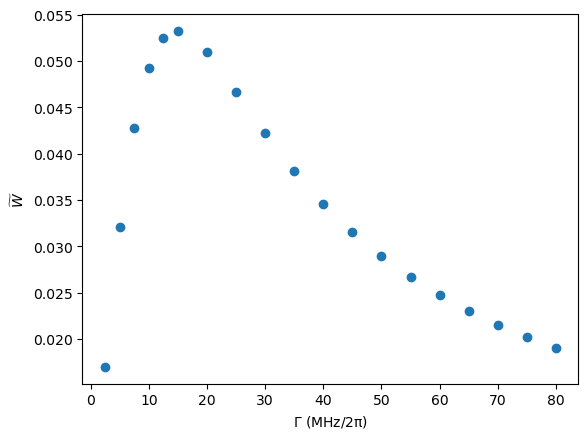

In [57]:
plt.figure()
#plt.title('W_{exp}')
plt.scatter(Gammas,wfic)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('$\widetilde{W}$')
plt.xlabel('$Γ$ (ΜΗz/2π)')
#plt.ylim(0)
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

In [59]:
wfic

[0.016985140309914805,
 0.0320627845098643,
 0.0427381150129642,
 0.04927510125611784,
 0.05244160550052404,
 0.05323276788272633,
 0.05092828576006249,
 0.046664646039257594,
 0.04221031180456492,
 0.03814761538975409,
 0.03460635152198925,
 0.031562669060320944,
 0.028949951681627974,
 0.02669753370346309,
 0.024742766763003646,
 0.023033524761463867,
 0.021527525760336255,
 0.02019076874180981,
 0.01899594638392355]

## Fluctuation Spectrum

In [62]:
def H_I_(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += 2*np.pi*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [64]:
def H_0_(F,Delta):
    H0 = 0*basis(N,0)*basis(N,0).dag()
    for l in range(len(F)):
        for mF in range(-F[l],F[l]+1):
            H0 += 2*np.pi*(Delta[l] + gF[l]*muB*mF*B)*base(F,l,mF)*base(F,l,mF).dag() 
    return H0

In [66]:
def H_1(F,Omega_p,eta):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += eta[ig-1]*2*np.pi*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return 1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [68]:
def S_(F,Delta,Omega_p,omega0,c,eta):
    H0_ = H_0_(F,Delta)
    HI_ = H_I_(F,Omega_p) 
    

    H0 = H0_ + HI_ 

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))
    #L0 = sum(c)

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    V1 = H_1(F,Omega_p,eta)
    
    rho = steadystate(H0,c) #!

    V1rho = V1*rho

    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    #eye = np.array(operator_to_vector(tensor(qeye(N),qeye(Nmotion))))
    eye = np.eye(N**2)
    inve = inv(-(L0+1j*2*np.pi*omega0*eye))

    s = np.matmul(inve,V1rho)

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            S[j,i] = s[N*i+j][0]

    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)


    return np.matrix.trace(S)

In [70]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

omega0=1.4
eta=[0.044,0.044,-0.044]
GammaJgJe = 2.44745*2*np.pi
c_ops5 = c_ops(F,GammaJgJe)


params = dict(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops5,eta=eta)

In [72]:
Gammas

array([ 2.44745,  5.     ,  7.5    , 10.     , 12.5    , 15.     ,
       20.     , 25.     , 30.     , 35.     , 40.     , 45.     ,
       50.     , 55.     , 60.     , 65.     , 70.     , 75.     ,
       80.     ])

In [74]:
ws = []
for GammaJgJe in tqdm(2*np.pi*Gammas):
    c_ops_ = c_ops(F,GammaJgJe)
    A_m = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_,eta=eta)
    A_p = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_,eta=eta)
    ws.append((2*A_m-2*A_p).real)

100%|██████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 15.94it/s]


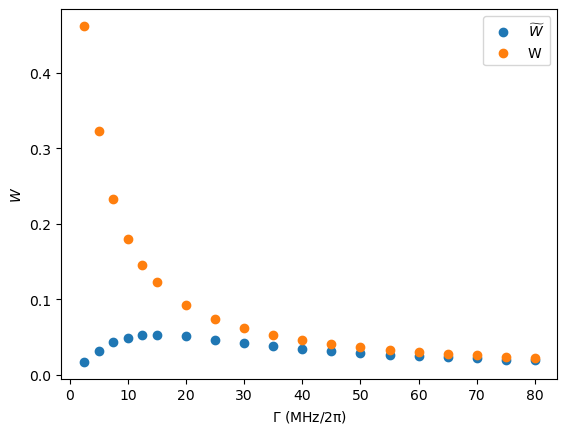

In [76]:
plt.figure()
#plt.title('W_{exp}')
plt.scatter(Gammas,wfic,label='$\widetilde{W}$')
plt.scatter(Gammas,ws,label='W')
#plt.xlim(0,5000)
plt.legend()
plt.ylabel('$W$')
plt.xlabel('$Γ$ (ΜΗz/2π)')
#plt.yscale("log")
#plt.ylim(0)
#plt.xlim(0)
#plt.savefig("I1_eta_W.png",bbox_inches = "tight")


plt.show()

## Cooling

In [49]:
from scipy.optimize import minimize_scalar

In [50]:
def func(x,Nmax,nbar):
    
    Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))
    n = np.exp(-Nmax*x)*(np.exp((Nmax + 1)*x) -(Nmax+1)*np.exp(x) + Nmax)/(np.exp(x) -1)**2
    
    
    return np.abs(nbar - n/Z)

In [51]:
Nmax=14
nbar=3
res = minimize_scalar(func,args=(Nmax,nbar),bounds=(0, 1), method='bounded')

In [52]:
x = res.x

In [53]:
hbar = 1.054571817e-34
kB = 1.380649e-23
omega = 2*np.pi*1.4*10e6
#x = 0.184132
Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))

T = hbar*omega/(kB*x)
T

0.002527075613606284

In [54]:
P = []
for i in range(Nmax+1): #Nmotion=15 but for <n> =3 keep up to i=10
    P.append(np.exp(-i*x)/Z)

In [55]:
Pn = []
for i in range(Nmax+1):
    Pn.append(np.exp(-i*x)/Z*i)

In [56]:
t = []
n = []
for i in range(Nmax+1):
    t.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])

In [57]:
nMC = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC +=np.array(n[i])*P[i]

In [58]:
t1 = []
n1= []
for i in range(Nmax+1):
    t1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_5.txt")[:, 0])
    n1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_5.txt")[:, 1])                                                                                

In [59]:
nMC1 = np.zeros(len(t1[0]))
for i in range(Nmax+1):
    nMC1 +=np.array(n1[i])*P[i]

In [60]:
t2 = []
n2 = []
for i in range(Nmax+1):
    t2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_7.5.txt")[:, 0])
    n2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_7.5.txt")[:, 1])        

In [61]:
nMC2 = np.zeros(len(t2[0]))
for i in range(Nmax+1):
    nMC2 +=np.array(n2[i])*P[i]

In [62]:
t3 = []
n3= []
for i in range(Nmax+1):
    t3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_10.txt")[:, 0])
    n3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_10.txt")[:, 1])        

In [63]:
nMC3 = np.zeros(len(t3[0]))
for i in range(Nmax+1):
    nMC3 +=np.array(n3[i])*P[i]

In [64]:
t4 = []
n4= []
for i in range(Nmax+1):
    t4.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_12.5.txt")[:, 0])
    n4.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_12.5.txt")[:, 1])        

In [65]:
nMC4 = np.zeros(len(t4[0]))
for i in range(Nmax+1):
    nMC4 +=np.array(n4[i])*P[i]

In [66]:
t5 = []
n5= []
for i in range(Nmax+1):
    t5.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_15.txt")[:, 0])
    n5.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_15.txt")[:, 1])        

In [67]:
nMC5 = np.zeros(len(t5[0]))
for i in range(Nmax+1):
    nMC5 +=np.array(n5[i])*P[i]

In [68]:
t6 = []
n6 = []
for i in range(Nmax+1):
    t6.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_20.txt")[:, 0])
    n6.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_20.txt")[:, 1])        

In [69]:
nMC6 = np.zeros(len(t6[0]))
for i in range(Nmax+1):
    nMC6 +=np.array(n6[i])*P[i]

In [70]:
t7 = []
n7 = []
for i in range(Nmax+1):
    t7.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_25.txt")[:, 0])
    n7.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_25.txt")[:, 1])        

In [71]:
nMC7 = np.zeros(len(t7[0]))
for i in range(Nmax+1):
    nMC7 +=np.array(n7[i])*P[i]

In [72]:
t8 = []
n8 = []
for i in range(Nmax+1):
    t8.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_30.txt")[:, 0])
    n8.append(np.loadtxt(""+str(path_name)+"data_Gamma25/data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_30.txt")[:, 1])        

In [73]:
nMC8 = np.zeros(len(t8[0]))
for i in range(Nmax+1):
    nMC8 +=np.array(n8[i])*P[i]

In [74]:
t9 = []
n9 = []
for i in range(Nmax+1):
    t9.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_35.txt")[:, 0])
    n9.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_35.txt")[:, 1])        

In [75]:
nMC9 = np.zeros(len(t9[0]))
for i in range(Nmax+1):
    nMC9 +=np.array(n9[i])*P[i]

In [76]:
t10 = []
n10 = []
for i in range(Nmax+1):
    t10.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_40.txt")[:, 0])
    n10.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_40.txt")[:, 1])        

In [77]:
nMC10 = np.zeros(len(t10[0]))
for i in range(Nmax+1):
    nMC10 +=np.array(n10[i])*P[i]

In [78]:
t11 = []
n11 = []
for i in range(Nmax+1):
    t11.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_45.txt")[:, 0])
    n11.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_45.txt")[:, 1])        

In [79]:
nMC11 = np.zeros(len(t11[0]))
for i in range(Nmax+1):
    nMC11 +=np.array(n11[i])*P[i]

In [80]:
t12 = []
n12 = []
for i in range(Nmax+1):
    t12.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_50.txt")[:, 0])
    n12.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_50.txt")[:, 1])        

In [81]:
nMC12 = np.zeros(len(t12[0]))
for i in range(Nmax+1):
    nMC12 +=np.array(n12[i])*P[i]

In [82]:
t13 = []
n13 = []
for i in range(Nmax+1):
    t13.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_55.txt")[:, 0])
    n13.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_55.txt")[:, 1])        

In [83]:
nMC13 = np.zeros(len(t13[0]))
for i in range(Nmax+1):
    nMC13 +=np.array(n13[i])*P[i]

In [84]:
t14 = []
n14 = []
for i in range(Nmax+1):
    t14.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_60.txt")[:, 0])
    n14.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_60.txt")[:, 1])        

In [85]:
nMC14 = np.zeros(len(t14[0]))
for i in range(Nmax+1):
    nMC14 +=np.array(n14[i])*P[i]

In [86]:
t15 = []
n15 = []
for i in range(Nmax+1):
    t15.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_65.txt")[:, 0])
    n15.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_65.txt")[:, 1])        

In [87]:
nMC15 = np.zeros(len(t15[0]))
for i in range(Nmax+1):
    nMC15 +=np.array(n15[i])*P[i]

In [88]:
t16 = []
n16 = []
for i in range(Nmax+1):
    t16.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_70.txt")[:, 0])
    n16.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_70.txt")[:, 1])        

In [89]:
nMC16 = np.zeros(len(t16[0]))
for i in range(Nmax+1):
    nMC16 +=np.array(n16[i])*P[i]

In [90]:
t17 = []
n17 = []
for i in range(Nmax+1):
    t17.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_75.txt")[:, 0])
    n17.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_75.txt")[:, 1])        

In [91]:
nMC17 = np.zeros(len(t17[0]))
for i in range(Nmax+1):
    nMC17 +=np.array(n17[i])*P[i]

In [92]:
t18 = []
n18 = []
for i in range(Nmax+1):
    t18.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_80.txt")[:, 0])
    n18.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_state_7_Gamma_80.txt")[:, 1])       

In [93]:
nMC18 = np.zeros(len(t18[0]))
for i in range(Nmax+1):
    nMC18 +=np.array(n18[i])*P[i]

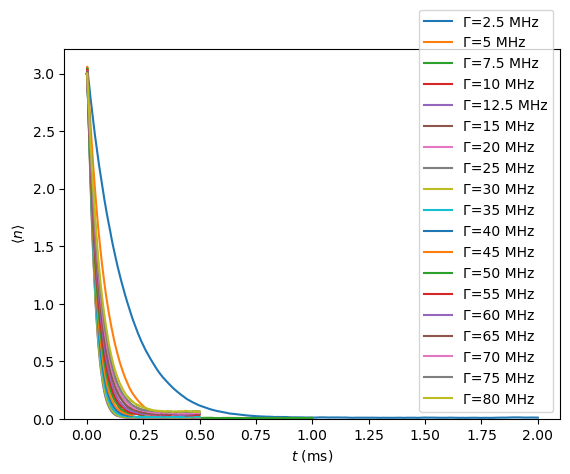

In [94]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t[0]*1e-3,nMC,label='Γ=2.5 ΜΗz')
plt.plot(t1[0]*1e-3,nMC1,label='Γ=5 ΜΗz')
plt.plot(t2[0]*1e-3,nMC2,label='Γ=7.5 ΜΗz')
plt.plot(t3[0]*1e-3,nMC3,label='Γ=10 ΜΗz')
plt.plot(t4[0]*1e-3,nMC4,label='Γ=12.5 ΜΗz')
plt.plot(t5[0]*1e-3,nMC5,label='Γ=15 ΜΗz')
plt.plot(t6[0]*1e-3,nMC6,label='Γ=20 ΜΗz')
plt.plot(t7[0]*1e-3,nMC7,label='Γ=25 ΜΗz')
plt.plot(t8[0]*1e-3,nMC8,label='Γ=30 ΜΗz')
plt.plot(t9[0]*1e-3,nMC9,label='Γ=35 ΜΗz')
plt.plot(t10[0]*1e-3,nMC10,label='Γ=40 ΜΗz')
plt.plot(t11[0]*1e-3,nMC11,label='Γ=45 ΜΗz')
plt.plot(t12[0]*1e-3,nMC12,label='Γ=50 ΜΗz')
plt.plot(t13[0]*1e-3,nMC13,label='Γ=55 ΜΗz')
plt.plot(t14[0]*1e-3,nMC14,label='Γ=60 ΜΗz')
plt.plot(t15[0]*1e-3,nMC15,label='Γ=65 ΜΗz')
plt.plot(t16[0]*1e-3,nMC16,label='Γ=70 ΜΗz')
plt.plot(t17[0]*1e-3,nMC17,label='Γ=75 ΜΗz')
plt.plot(t18[0]*1e-3,nMC18,label='Γ=80 ΜΗz')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,0.1)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

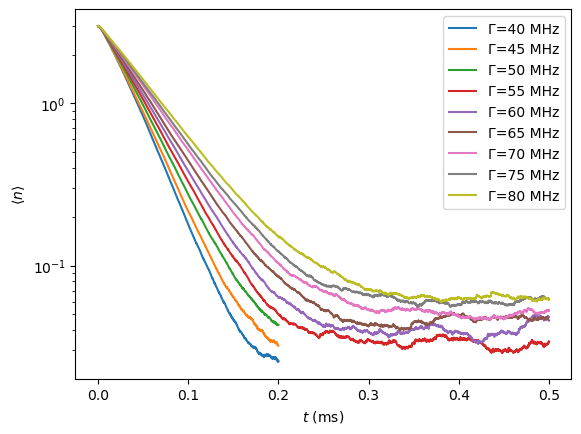

In [95]:
plt.figure()
#plt.title("I=1")

plt.plot(t10[0]*1e-3,nMC10,label='Γ=40 ΜΗz')
plt.plot(t11[0]*1e-3,nMC11,label='Γ=45 ΜΗz')
plt.plot(t12[0]*1e-3,nMC12,label='Γ=50 ΜΗz')
plt.plot(t13[0]*1e-3,nMC13,label='Γ=55 ΜΗz')
plt.plot(t14[0]*1e-3,nMC14,label='Γ=60 ΜΗz')
plt.plot(t15[0]*1e-3,nMC15,label='Γ=65 ΜΗz')
plt.plot(t16[0]*1e-3,nMC16,label='Γ=70 ΜΗz')
plt.plot(t17[0]*1e-3,nMC17,label='Γ=75 ΜΗz')
plt.plot(t18[0]*1e-3,nMC18,label='Γ=80 ΜΗz')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,0.1)
plt.yscale("log")


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [96]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [97]:
t[0][750]

750.37518759

In [98]:
p0 = (3, .001,.001)
popt, pcov = curve_fit(func,t[0][:150],nMC[:150],p0)
popt

array([ 3.06869919,  0.00604432, -0.04246837])

In [99]:
t1[0][4000]

400.040004

In [100]:
p0 = (3, .001,.001)
popt1, pcov = curve_fit(func,t1[0][:4000],nMC1[:4000],p0)
popt1

array([ 3.10998943,  0.01243756, -0.02140035])

In [101]:
t2[0][3000]

300.030003

In [102]:
p0 = (3, .001,.001)
popt2, pcov = curve_fit(func,t2[0][:3000],nMC2[:3000],p0)
popt2

array([ 3.15591215,  0.01736605, -0.02648777])

In [103]:
t3[0][4000]

200.020002

In [104]:
p0 = (3, .001,.001)
popt3, pcov = curve_fit(func,t3[0][:4000],nMC3[:4000],p0)
popt3

array([ 3.18264886,  0.02123503, -0.05146276])

In [105]:
t4[0][3000]

150.0150015

In [106]:
p0 = (3, .001,.001)
popt4, pcov = curve_fit(func,t4[0][:3000],nMC4[:3000],p0)
popt4

array([ 3.19664214,  0.02420889, -0.07602191])

In [107]:
t5[0][2500]

125.01250125

In [108]:
p0 = (3, .001,.001)
popt5, pcov = curve_fit(func,t5[0][:2500],nMC5[:2500],p0)
popt5

array([ 3.2055054 ,  0.02587487, -0.11054832])

In [109]:
t6[0][2000]

100.010001

In [110]:
p0 = (3, .001,.001)
popt6, pcov = curve_fit(func,t6[0][:2000],nMC6[:2000],p0)
popt6

array([ 3.20076277,  0.02682694, -0.17845957])

In [111]:
t7[0][2000]

100.010001

In [112]:
p0 = (3, .001,.001)
popt7, pcov = curve_fit(func,t7[0][:2000],nMC7[:2000],p0)
popt7

array([ 3.19444062,  0.02746854, -0.16639388])

In [113]:
t8[0][2000]

100.010001

In [114]:
p0 = (3, .001,.001)
popt8, pcov = curve_fit(func,t8[0][:2000],nMC8[:2000],p0)
popt8

array([ 3.1927587 ,  0.0264106 , -0.17103113])

In [115]:
t9[0][2000]

100.010001

In [116]:
p0 = (3, .001,.001)
popt9, pcov = curve_fit(func,t9[0][:2000],nMC9[:2000],p0)
popt9

array([ 3.16807264,  0.02536854, -0.15680798])

In [117]:
t10[0][2000]

100.02500625

In [118]:
p0 = (3, .001,.001)
popt10, pcov = curve_fit(func,t10[0][:2000],nMC10[:2000],p0)
popt10

array([ 3.1533084 ,  0.02381132, -0.15895685])

In [119]:
p0 = (3, .001,.001)
popt11, pcov = curve_fit(func,t11[0][:2000],nMC11[:2000],p0)
popt11

array([ 3.13788598,  0.02323756, -0.1257475 ])

In [120]:
p0 = (3, .001,.001)
popt12, pcov = curve_fit(func,t12[0][:2000],nMC12[:2000],p0)
popt12

array([ 3.12256905,  0.02135328, -0.13098415])

In [121]:
t13[0][2000]

100.010001

In [122]:
p0 = (3, .001,.001)
popt13, pcov = curve_fit(func,t13[0][:2000],nMC13[:2000],p0)
popt13

array([ 3.11534028,  0.01998125, -0.12966641])

In [123]:
p0 = (3, .001,.001)
popt14, pcov = curve_fit(func,t14[0][:2000],nMC14[:2000],p0)
popt14

array([ 3.10415086,  0.01891072, -0.11720818])

In [124]:
p0 = (3, .001,.001)
popt15, pcov = curve_fit(func,t15[0][:2000],nMC15[:2000],p0)
popt15

array([ 3.09185585,  0.01779071, -0.1121446 ])

In [125]:
p0 = (3, .001,.001)
popt16, pcov = curve_fit(func,t16[0][:3000],nMC16[:3000],p0)
popt16

array([ 3.09896877,  0.01724191, -0.03744678])

In [126]:
t17[0][4000]

200.020002

In [127]:
p0 = (3, .001,.001)
popt17, pcov = curve_fit(func,t17[0][:3500],nMC17[:3500],p0)
popt17

array([ 3.09908338,  0.01683062, -0.00857184])

In [128]:
p0 = (3, .001,.001)
popt18, pcov = curve_fit(func,t18[0][:3500],nMC18[:3500],p0)
popt18

array([ 3.09209911e+00,  1.58565784e-02, -1.51578512e-03])

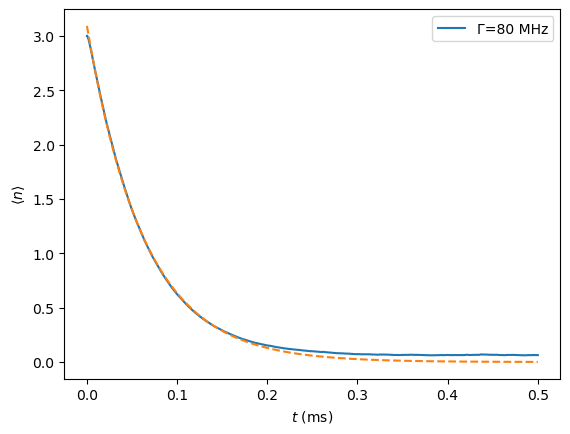

In [129]:
plt.figure()
#plt.title("I=1")


#plt.plot(t[0]*1e-3,nMC,label='Γ=2.5 ΜΗz')
#plt.plot(t[0]*1e-3,func(t[0], *popt),'--')
#plt.plot(t1[0]*1e-3,nMC1,label='Γ=5 ΜΗz')
#plt.plot(t1[0]*1e-3,func(t1[0], *popt1),'--')
#plt.plot(t2[0]*1e-3,nMC2,label='Γ=7.5 ΜΗz')
#plt.plot(t2[0]*1e-3,func(t2[0], *popt2),'--')
#plt.plot(t3[0]*1e-3,nMC3,label='Γ=10 ΜΗz')
#plt.plot(t3[0]*1e-3,func(t3[0], *popt3),'--')
#plt.plot(t4[0]*1e-3,nMC4,label='Γ=12.5ΜΗz')
#plt.plot(t4[0]*1e-3,func(t4[0], *popt4),'--')
#plt.plot(t5[0]*1e-3,nMC5,label='Γ=15 ΜΗz')
#plt.plot(t5[0]*1e-3,func(t5[0], *popt5),'--')
#plt.plot(t6[0]*1e-3,nMC6,label='Γ=20 ΜΗz')
#plt.plot(t6[0]*1e-3,func(t6[0], *popt6),'--')
#plt.plot(t7[0]*1e-3,nMC7,label='Γ=25 ΜΗz')
#plt.plot(t7[0]*1e-3,func(t7[0], *popt7),'--')
#plt.plot(t8[0]*1e-3,nMC8,label='Γ=30 ΜΗz')
#plt.plot(t8[0]*1e-3,func(t8[0], *popt8),'--')
#plt.plot(t9[0]*1e-3,nMC9,label='Γ=35 ΜΗz')
#plt.plot(t9[0]*1e-3,func(t9[0], *popt9),'--')
#plt.plot(t10[0]*1e-3,nMC10,label='Γ=40 ΜΗz')
#plt.plot(t10[0]*1e-3,func(t10[0], *popt10),'--')
#plt.plot(t11[0]*1e-3,nMC11,label='Γ=45 ΜΗz')
#plt.plot(t11[0]*1e-3,func(t11[0], *popt11),'--')
#plt.plot(t12[0]*1e-3,nMC12,label='Γ=50 ΜΗz')
#plt.plot(t12[0]*1e-3,func(t12[0], *popt12),'--')
#plt.plot(t13[0]*1e-3,nMC13,label='Γ=55 ΜΗz')
#plt.plot(t13[0]*1e-3,func(t13[0], *popt13),'--')
#plt.plot(t14[0]*1e-3,nMC14,label='Γ=60 ΜΗz')
#plt.plot(t14[0]*1e-3,func(t14[0], *popt14),'--')
#plt.plot(t15[0]*1e-3,nMC15,label='Γ=65 ΜΗz')
#plt.plot(t15[0]*1e-3,func(t15[0], *popt15),'--')
#plt.plot(t16[0]*1e-3,nMC16,label='Γ=70 ΜΗz')
#plt.plot(t16[0]*1e-3,func(t16[0], *popt16),'--')
#plt.plot(t17[0]*1e-3,nMC17,label='Γ=75 ΜΗz')
#plt.plot(t17[0]*1e-3,func(t17[0], *popt17),'--')
plt.plot(t18[0]*1e-3,nMC18,label='Γ=80 ΜΗz')
plt.plot(t18[0]*1e-3,func(t18[0], *popt18),'--')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
#plt.ylim(0)
#plt.yscale("log")
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axhline(0, linestyle='--' )
#plt.xlim(0.05,0.1)


plt.legend()
#plt.savefig("/Users/kfouka/Desktop/ΠΕ ++/qudits/eit cooling/numerics/MC/I1/figures/I1_cooling_etas_fittings_G25.png",bbox_inches = "tight")
plt.show()

In [130]:
wexp = np.array([popt[1],popt1[1],popt2[1],popt3[1],popt4[1],popt5[1],popt6[1],popt7[1],popt8[1],popt9[1],popt10[1],popt11[1],popt12[1],
                popt13[1],popt14[1],popt15[1],popt16[1],popt17[1],popt18[1]])

In [131]:
wexp

array([0.00604432, 0.01243756, 0.01736605, 0.02123503, 0.02420889,
       0.02587487, 0.02682694, 0.02746854, 0.0264106 , 0.02536854,
       0.02381132, 0.02323756, 0.02135328, 0.01998125, 0.01891072,
       0.01779071, 0.01724191, 0.01683062, 0.01585658])

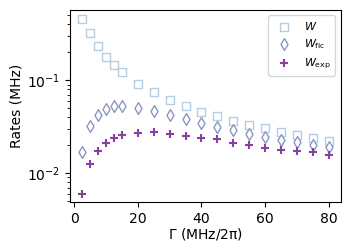

In [132]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(Gammas,ws,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(Gammas,wfic,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
plt.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('$Γ$ (ΜΗz/2π)',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

In [133]:
ws

[0.4621341685473364,
 0.3231855569894994,
 0.2328926117789355,
 0.1797185892355439,
 0.14568651277112613,
 0.12225449545818043,
 0.09226046843254611,
 0.07394260692742269,
 0.06161029229272555,
 0.052742506297802465,
 0.046056511039894554,
 0.04083221220892271,
 0.03663464125482109,
 0.03318573115626628,
 0.03029950310006941,
 0.02784689944810467,
 0.025735575754528936,
 0.02389772475372635,
 0.02228244146259587]

In [134]:
wexp

array([0.00604432, 0.01243756, 0.01736605, 0.02123503, 0.02420889,
       0.02587487, 0.02682694, 0.02746854, 0.0264106 , 0.02536854,
       0.02381132, 0.02323756, 0.02135328, 0.01998125, 0.01891072,
       0.01779071, 0.01724191, 0.01683062, 0.01585658])

## Γ=2.44745 (ΜΗz/2π)

In [136]:
etas = [0.01,0.025,0.044,0.075,0.1]
GammaJgJe = 2.44745
c_ops_ = c_ops(F,GammaJgJe)

In [137]:
wfic_1 = []
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    abs_r = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=omega0)
    abs_b = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=-omega0)
    wfic_1.append((abs_r-abs_b).real)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


In [138]:
c_ops_ = c_ops(F,2*np.pi*GammaJgJe)

In [139]:
ws_1 = []
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    A_m = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_,eta=eta)
    A_p = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_,eta=eta)
    ws_1.append((2*A_m-2*A_p).real)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


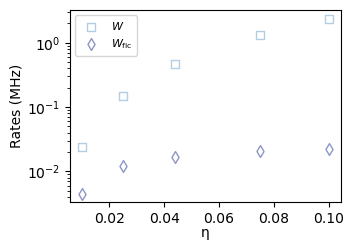

In [140]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_1,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_1,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
#plt.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

In [141]:
etas

[0.01, 0.025, 0.044, 0.075, 0.1]

In [142]:
t_ = []
n_ = []
for i in range(Nmax+1):
    t_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.01_improved.txt")[:, 0])
    n_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.01_improved.txt")[:, 1])

In [143]:
nMC_ = np.zeros(len(t_[0]))
for i in range(Nmax+1):
    nMC_ +=np.array(n_[i])*P[i]

In [144]:
t_1 = []
n_1 = []
for i in range(Nmax+1):
    t_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.025_improved.txt")[:, 0])
    n_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.025_improved.txt")[:, 1])

In [145]:
nMC_1 = np.zeros(len(t_1[0]))
for i in range(Nmax+1):
    nMC_1 +=np.array(n_1[i])*P[i]

In [146]:
t_2 = []
n_2 = []
for i in range(Nmax+1):
    t_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.075_improved.txt")[:, 0])
    n_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.075_improved.txt")[:, 1])

In [147]:
nMC_2 = np.zeros(len(t_2[0]))
for i in range(Nmax+1):
    nMC_2 +=np.array(n_2[i])*P[i]

In [148]:
t_3 = []
n_3 = []
for i in range(Nmax+1):
    t_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.1_improved.txt")[:, 0])
    n_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_eta_0.1_improved.txt")[:, 1])

In [149]:
nMC_3 = np.zeros(len(t_3[0]))
for i in range(Nmax+1):
    nMC_3 +=np.array(n_3[i])*P[i]

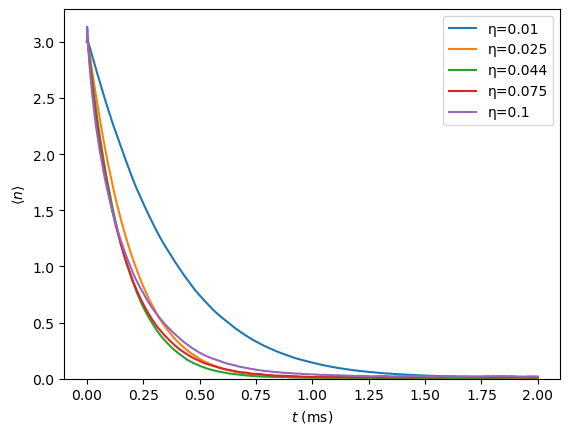

In [150]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t_[0]*1e-3,nMC_,label='η=0.01')
plt.plot(t_1[0]*1e-3,nMC_1,label='η=0.025')
plt.plot(t[0]*1e-3,nMC,label='η=0.044')
plt.plot(t_2[0]*1e-3,nMC_2,label='η=0.075')
plt.plot(t_3[0]*1e-3,nMC_3,label='η=0.1')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,0.1)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [151]:
ts = [t_[0],t_1[0],t[0],t_2[0],t_3[0]]
nMCs = [nMC_,nMC_1,nMC,nMC_2,nMC_3]

In [152]:
p0 = (3, .001,.001)
wexp_1 = []
for i in range(len(ts)):
    popt, pcov = curve_fit(func,ts[i],nMCs[i],p0)
    #print(popt)
    wexp_1.append(popt[1])

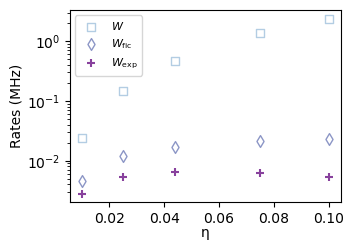

In [153]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_1,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_1,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
plt.scatter(etas,wexp_1,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

## Γ=20 (ΜΗz/2π)

In [155]:
GammaJgJe = 20
c_ops_ = c_ops(F,GammaJgJe)

In [156]:
wfic_2 = []
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    abs_r = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=omega0)
    abs_b = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=-omega0)
    wfic_2.append((abs_r-abs_b).real)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


In [157]:
ws_2 = []
c_ops_ = c_ops(F,2*np.pi*GammaJgJe)
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    A_m = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_,eta=eta)
    A_p = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_,eta=eta)
    ws_2.append((2*A_m-2*A_p).real)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


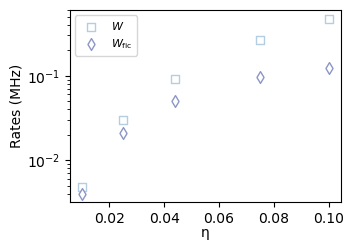

In [158]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_2,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_2,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
#plt.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

In [159]:
t_ = []
n_ = []
for i in range(Nmax+1):
    t_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.01_improved.txt")[:, 0])
    n_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.01_improved.txt")[:, 1])

In [160]:
nMC_ = np.zeros(len(t_[0]))
for i in range(Nmax+1):
    nMC_ +=np.array(n_[i])*P[i]

In [161]:
t_1 = []
n_1 = []
for i in range(Nmax+1):
    t_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.025_improved.txt")[:, 0])
    n_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.025_improved.txt")[:, 1])

In [162]:
nMC_1 = np.zeros(len(t_1[0]))
for i in range(Nmax+1):
    nMC_1 +=np.array(n_1[i])*P[i]

In [163]:
t_2 = []
n_2 = []
for i in range(Nmax+1):
    t_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.075_improved.txt")[:, 0])
    n_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.075_improved.txt")[:, 1])

In [164]:
nMC_2 = np.zeros(len(t_2[0]))
for i in range(Nmax+1):
    nMC_2 +=np.array(n_2[i])*P[i]

In [165]:
t_3 = []
n_3 = []
for i in range(Nmax+1):
    t_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.1_improved.txt")[:, 0])
    n_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_20.0_ntraj_500_eta_0.1_improved.txt")[:, 1])

In [166]:
nMC_3 = np.zeros(len(t_3[0]))
for i in range(Nmax+1):
    nMC_3 +=np.array(n_3[i])*P[i]

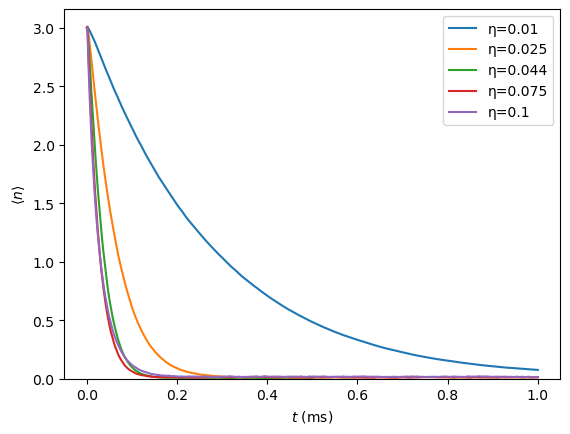

In [167]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t_[0]*1e-3,nMC_,label='η=0.01')
plt.plot(t_1[0]*1e-3,nMC_1,label='η=0.025')
plt.plot(t6[0]*1e-3,nMC6,label='η=0.044')
plt.plot(t_2[0]*1e-3,nMC_2,label='η=0.075')
plt.plot(t_3[0]*1e-3,nMC_3,label='η=0.1')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,0.1)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [168]:
p0 = (3, .001,.001)
wexp_2 = []
popt, pcov = curve_fit(func,t_[0],nMC_,p0)
print(popt)
wexp_2.append(popt[1])

[ 3.07230421  0.00360258 -0.01944415]


In [169]:
popt, pcov = curve_fit(func,t_1[0][:400],nMC_1[:400],p0)
print(popt)
wexp_2.append(popt[1])

[ 3.21182398  0.01607121 -0.02014155]


In [170]:
t6[0][4000]

200.020002

In [171]:
popt, pcov = curve_fit(func,t6[0][:4000],nMC6[:4000],p0)
print(popt)
wexp_2.append(popt[1])

[ 3.2685811   0.03026497 -0.03349624]


In [172]:
popt, pcov = curve_fit(func,t_2[0][:200],nMC_2[:200],p0)
print(popt)
wexp_2.append(popt[1])

[3.14944758e+00 3.82935593e-02 1.87636685e-04]


In [173]:
popt, pcov = curve_fit(func,t_3[0][:200],nMC_3[:200],p0)
print(popt)
wexp_2.append(popt[1])

[2.99198811 0.03668915 0.03225641]


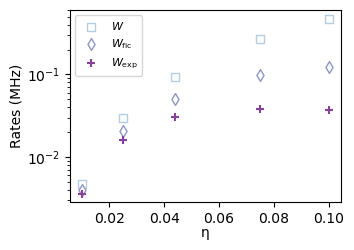

In [174]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_2,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_2,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
plt.scatter(etas,wexp_2,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

## Γ=80 (ΜΗz/2π)

In [176]:
GammaJgJe = 80
c_ops_ = c_ops(F,GammaJgJe)

In [177]:
wfic_3 = []
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    abs_r = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=omega0)
    abs_b = steck(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops_,omega=-omega0)
    wfic_3.append((abs_r-abs_b).real)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_24076\18842625.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


In [178]:
ws_3 = []
c_ops_ = c_ops(F,2*np.pi*GammaJgJe)
for ee in tqdm(etas):
    eta = [ee,ee,-ee]
    A_m = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_,eta=eta)
    A_p = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_,eta=eta)
    ws_3.append((2*A_m-2*A_p).real)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


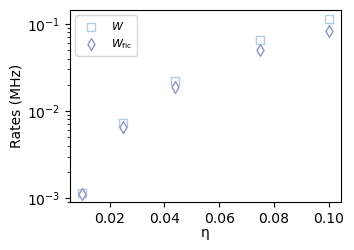

In [179]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_3,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_3,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
#plt.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

In [180]:
t_ = []
n_ = []
for i in range(Nmax+1):
    t_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.01_improved.txt")[:, 0])
    n_.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.01_improved.txt")[:, 1])

In [181]:
nMC_ = np.zeros(len(t_[0]))
for i in range(Nmax+1):
    nMC_ +=np.array(n_[i])*P[i]

In [182]:
t_1 = []
n_1 = []
for i in range(Nmax+1):
    t_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.025_improved.txt")[:, 0])
    n_1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.025_improved.txt")[:, 1])

In [183]:
nMC_1 = np.zeros(len(t_1[0]))
for i in range(Nmax+1):
    nMC_1 +=np.array(n_1[i])*P[i]

In [184]:
t_2 = []
n_2 = []
for i in range(Nmax+1):
    t_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.075_improved.txt")[:, 0])
    n_2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.075_improved.txt")[:, 1])

In [185]:
nMC_2 = np.zeros(len(t_2[0]))
for i in range(Nmax+1):
    nMC_2 +=np.array(n_2[i])*P[i]

In [186]:
t_3 = []
n_3 = []
for i in range(Nmax+1):
    t_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.1_improved.txt")[:, 0])
    n_3.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_80.0_ntraj_500_eta_0.1_improved.txt")[:, 1])

In [187]:
nMC_3 = np.zeros(len(t_3[0]))
for i in range(Nmax+1):
    nMC_3 +=np.array(n_3[i])*P[i]

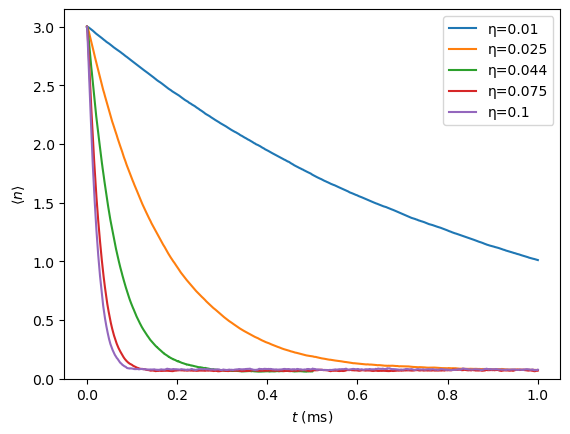

In [188]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t_[0]*1e-3,nMC_,label='η=0.01')
plt.plot(t_1[0]*1e-3,nMC_1,label='η=0.025')
plt.plot(t18[0]*1e-3,nMC18,label='η=0.044')
plt.plot(t_2[0]*1e-3,nMC_2,label='η=0.075')
plt.plot(t_3[0]*1e-3,nMC_3,label='η=0.1')

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,0.1)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [189]:
p0 = (3, .001,.001)
wexp_3 = []
popt, pcov = curve_fit(func,t_[0],nMC_,p0)
print(popt)
wexp_3.append(popt[1])

[3.01548999e+00 1.11028889e-03 2.98123608e-02]


In [190]:
popt, pcov = curve_fit(func,t_1[0],nMC_1,p0)
print(popt)
wexp_3.append(popt[1])

[3.05903157 0.00609379 0.05923268]


In [191]:
t18[0][6000]

300.030003

In [192]:
popt, pcov = curve_fit(func,t18[0][:6000],nMC18[:6000],p0)
print(popt)
wexp_3.append(popt[1])

[3.11098061 0.01644699 0.03945668]


In [193]:
popt, pcov = curve_fit(func,t_2[0][:150],nMC_2[:150],p0)
print(popt)
wexp_3.append(popt[1])

[3.18058354 0.03555683 0.02661658]


In [194]:
popt, pcov = curve_fit(func,t_3[0][:100],nMC_3[:100],p0)
print(popt)
wexp_3.append(popt[1])

[3.15927447 0.04439411 0.01399825]


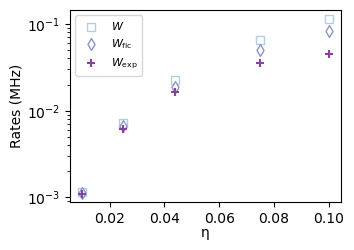

In [195]:
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': 10})
#plt.title('W_{exp}')
plt.scatter(etas,ws_3,marker='s',label=r'$W$',color='white',edgecolor = '#b3cde3')
plt.scatter(etas,wfic_3,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#8c96c6')
plt.scatter(etas,wexp_3,marker='+',label=r'$W_{\text{exp}}$',color='#88419d')
#plt.xlim(0,5000)
plt.legend(prop={'size': 8})
plt.ylabel('Rates (MHz)',labelpad=2)
plt.xlabel('η',labelpad=0)
#plt.ylim(0)
#plt.xlim(0)
plt.yscale("log")
#plt.savefig("I1_Ws_Gammas.pdf",bbox_inches = "tight")


plt.show()

In [196]:
plt.rcParams.update({'font.size':8 })

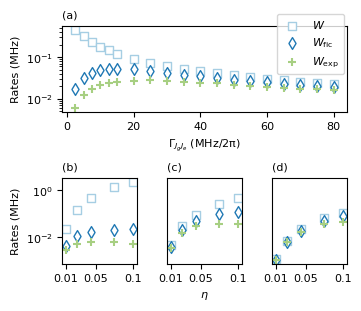

In [399]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=(3.5,3))

gs = GridSpec(2, 3, figure=fig)
gs.update(wspace=0.005, hspace=0.05)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

ax1.set_title(r'(a)',loc='left',fontdict={'fontsize': 8})
ax1.scatter(Gammas,ws,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax1.scatter(Gammas,wfic,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax1.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
ax1.set_ylabel('Rates (MHz)')
ax1.set_xlabel('$\Gamma_{J_gJ_e}$ (ΜΗz/2π)')

ax1.set_yscale('log')
ax1.legend(prop={'size': 8},bbox_to_anchor=(1.01, 1.2))
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title(r'(b)',loc='left',fontdict={'fontsize': 8})
ax2.scatter(etas,ws_1,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax2.scatter(etas,wfic_1,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax2.scatter(etas,wexp_1,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
ax2.set_xlim(0.005,0.105)
ax2.set_xticks([0.01,0.05,0.1])
ax2.set_xticklabels(["0.01","0.05","0.1"])
ax2.set_ylabel('Rates (MHz)')
#ax2.set_xlabel('$η$')

ax2.set_yscale('log')
#ax2.set_xscale('log')
#ax2.legend(prop={'size': 8})

ax3 = fig.add_subplot(gs[1, 1], sharey=ax2)
ax3.set_title(r'(c)',loc='left',fontdict={'fontsize': 8})
ax3.scatter(etas,ws_2,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax3.scatter(etas,wfic_2,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax3.scatter(etas,wexp_2,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
ax3.tick_params(left=False, labelleft=False)
#plt.xlim(0,5000)
#plt.legend()
#ax3.set_ylabel('Rates (MHz)')
ax3.set_xlabel('$η$')
ax3.set_xlim(0.005,0.105)
ax3.set_xticks([0.01,0.05,0.1])
ax3.set_xticklabels(["0.01","0.05","0.1"])

ax3.set_yscale('log')
#ax3.set_xscale('log')
#ax3.legend(prop={'size': 8})



ax4 = fig.add_subplot(gs[1, 2], sharey=ax2)
ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 8})
ax4.scatter(etas,ws_3,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax4.scatter(etas,wfic_3,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax4.scatter(etas,wexp_3,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
ax4.tick_params(left=False, labelleft=False)
#ax4.set_xlim(0.005,0.105)
#plt.legend()
#ax4.set_ylabel('Rates (MHz)')
#ax4.set_xlabel('$η$')
ax4.set_xlim(0.005,0.105)
ax4.set_xticks([0.01,0.05,0.1])
ax4.set_xticklabels(["0.01","0.05","0.1"])

ax4.set_yscale('log')
#ax4.set_xscale('log')
#ax4.legend(prop={'size': 8})


#plt.xlim(45,55)

#fig.suptitle("GridSpec")
#format_axes(fig)

plt.savefig("I1_rates_Gammas_etas.pdf",bbox_inches = "tight")


plt.show()